# SunStride Business Analysis

## Overview

SunStride is an adventure travel company for teens that sends students all over the world each summer season. SunStride needs a system for projecting how many students they can expect to return next summer so they can approriately allocate funds and pay their outfitters' non-refundable deposits almost a year in advance. I built the company a predictive model using a random forest classifier and it resulted in a model that is able to predict a student will return with a precision score of ~.85. Based on this result, SunStride is able to make a confident determination of how many students will return and how much money they may need to spend on marketing to fill in the rest of the spaces with new students. The model identified the feature "Years at camp" as the most impactful when the model was making splits. This indicates that if SunStride is able to retain a student for at least a second summer season then they are significantly more likely to continue seeing that student return for future summers. To retain students I recommend SunStride focus any marketing spend on finding new, young customers who have many years left to return and keeping these students as engaged as possible after they have signed up. 

## Business Problem

Because the company only operates its trips in the summer, its cash flow is cyclical annually with a major influx in August when enrollment opens and then it tapers off throughout the rest of the year. This inflow of cash is crucial, as it allows the company to hire and pay the outfitters that will run the next seasons' trips (many of whom require a majority of the payment up front and a year in advance to hold the spots!). SunStride needs a more robust system for projecting how many students they can expect to return the following summer so they can project how many spaces to hold (and pay for) for activities the next season. 

The final model I built SunStride uses random forest classification to sort students into two categories: returning (designated with a 1) or not (a 0). The model takes into account features like the student's grade, gender, and their overall rating of the trip they just finished (rated on a scale from 1-6). Initially, the models I built were drastically overfitting to the training data - as many tree-like classifiers tend to do if left un-tuned. With proper tuning through grid-searching and additional model iterations, the final model achieved an accuracy score of .86, a precision score of .85 and a recall score of .84. 

For this analysis, I am focused on the precision score which represents the ratio of false positives predicted by the model. A false positive means the model is predicting that a student will return, when they do not actually re-enroll the next season. The lower the precision score (between 0 and 1.0) the higher the number of false positives predicted. If SunStride were to use a model that predicted many false positives then they may allocate funds incorrectly, as they are projecting a higher student return than the company will actually see. Of course there are also new students that come on board each season, but it requires less marketing spend and less effort in the onboarding process to retain an existing student than it does to onboard a new student/family. 

A false negative, on the other hand, which is tracked best through the recall score, represents our models ability to predict a student will not return when they actually do. This is not necessarily ideal either for SunStride, as it represents money left on the table or it may miss earning opportunities by not having space for these students, but ultimately it does not cause any immediate negative impact on the business if not enough spots are offered because no money is exchanging hands with outfitters in this case.

## Data Understanding

The data was provided by SunStride from their customer management system. This system houses all the demographic data fro each custemr along with the post-trip ratings and opinions that each student reported after travelling with the company. Specifically, we are analyzing is the 2022 summer's student data, because we are able to identify and track whether or not these students returned for the 2023 season. The target variable is the student's 2023 season's status, which was distilled down to represent whether the student returned (Enrolled) or did not (which could have been represented by a few other designations that all meant the student did not travel with SunStride again). 



## Data Preparation

The features included in the dataset are a mix of both categorical and numeric varibles. Significant pre-processing was needed to clean and prepare the data for final modeling. During this cleaning stage, many columns were dropped from the dataset for various reasons (such as too many unique values to impactful in a predictive model, etc), and all of these reasons are documented in the "Final_Data_Cleaning" notebook linked here along with detailed descriptions of all the features that are included in the final model.

Some additional pre-processing steps included the imputation of missing column values and the OneHotEncoding of the categorical freatures. The numeric features in this case were not scaled, because the final model does not take the measure of distance into account, therefore the varying scales of the numeric features does not negatively impact the model's performance. 

First, I'll run all necessary modeling imports and then import my cleaned data csv:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
df = pd.read_csv('../data/cleaned_student_enrolled_demographics.csv')
df

,2021 > Grade,Gender,Years at camp,Lead source,2021 > trip + section names (all),2021 > Enrolled sibling count,2021 > Is your child attending with a friend?,2021 ^Expectations,2021 ^Trip Length,2021 ^^Interested in Another Trip?,2021 ^^^^Leader Rating of Student,Changed Trip,rating,target
0,11th,Male,1,Friend,Kilimanjaro 2,0.0,Yes,Met expectations,Just Right,Yes,6,0,5,0
1,8th,Male,2,Friend,Belize+Costa Rica 2,0.0,Yes,Met expectations,Too Short,Yes,3,0,5,1
2,10th,Female,2,Friend,Spain+Morocco 3,0.0,Yes,Exceeded expectations,Just Right,Yes,4,0,5,0
3,12th,Male,2,Word of Mouth,Slovenia 1,0.0,No,Met expectations,Just Right,No,5,0,5,0
4,11th,Female,1,Friend,Hawaiian Islands 3,0.0,Yes,Met expectations,Just Right,Not Sure,6,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,8th,Female,3,Friend,British Columbia 2,0.0,No,Exceeded expectations,Just Right,Yes,6,1,5,1
1725,10th,Female,2,Friend,Chamonix Alps 2,0.0,No,Exceeded expectations,Just Right,Yes,3,0,5,0
1726,8th,Female,2,Friend,Pacific Northwest 1,0.0,Yes,Met expectations,Just Right,Not Sure,5,0,5,1
1727,10th,Female,1,Friend,Hawaiian Islands 3,0.0,No,Met expectations,Just Right,Not Sure,4,0,5,0


### Train-test Splitting
> - Before any modeling can begin, I will split the training and testing data. Performing this step now prevents data leakage by keeping the testing data hidden throughout the entire modeling process until a final model is chosen. 

In [3]:
X_initial = df.drop('target', axis=1)
y = df['target']
X_train_in, X_test_in, y_train, y_test = train_test_split(X_initial, y, random_state=42)

In [4]:
X_train_in.shape, y_train.shape

((1296, 13), (1296,))

### Baseline Understanding: Analyzing 'target' Column and Building a DummyClassifier
> - First I will check the value counts in the taget column and normalize the output to see the ratio of students that returned to the overall dataset. 
> - Then I will build a dummy model, which should result in scores that mirror the value I discovered in the normailzed value_counts of the 'target' column, becasue the dummy model will only pick the positive (1) value class. Of course this inital model will only act to represent a starting point for analysis, as it would not be useful to SunStride to have so many false positive predictions. 

In [5]:
# Analyzing the 'target' column or y training values
y_train.value_counts(normalize=True)

0    0.516204
1    0.483796
Name: target, dtype: float64

> - I expect to see the ~.48 value for the positive class (designating the model is predicting that a student will return) to be repeated in the scoring for the dummy model:

In [6]:
# Instantiating the Dummy model with hyperparameters set to ALWAYS pick the positive class.
baseline = DummyClassifier(strategy='constant', constant=1)

In [7]:
# Fitting the baseline model to the training data
baseline.fit(X_train_in, y_train)

DummyClassifier(constant=1, strategy='constant')

In [8]:
# Generating predictions to be used for scoring the model
y_base_pred = baseline.predict(X_train_in)

Baseline Model: Training Data Scores
-----------------------------
Training Accuracy:  0.4837962962962963
Training Precision: 0.4837962962962963
Training Recall:    1.0


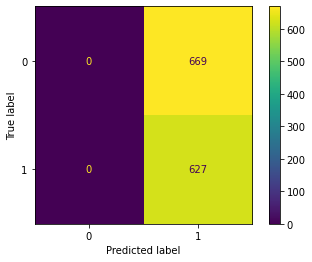

In [9]:
# Generating a report for all the baseline scores - this format will be repeated for 
## future models to keep reporting consistent throughout the project.

print('Baseline Model: Training Data Scores')
print('-----------------------------')
print(f'Training Accuracy:  {accuracy_score(y_train, y_base_pred)}')
print(f'Training Precision: {precision_score(y_train, y_base_pred)}')
print(f'Training Recall:    {recall_score(y_train, y_base_pred)}')
ConfusionMatrixDisplay.from_predictions(y_train, y_base_pred);

> - This model's precision score represents the baseline that I will seek to improve through various modeling techniques and tuning. My goal moving forward will be to improve upon this ~.48 precision score. I plan to continue to include the other scores in my analysis, however my focus on optimizing the precision score will remain.

## Categorical Feature Pre-Processing:

### OneHotEncoder
> - In order to use the categorical feature columns in the classifier models I will build, I need to first OneHotEncode out each of the columns' values. This means that I will be creating a matrix of all binary values that the classifier will be able to read and use to make splitting decisions.
> - For example: the OneHotEncoder dealing with the 'Gender' column which contains either 'Male' or 'Female' will split this column into two for each record in the dataset. If the student's gender is designated male before the split then the resulting 'Gender_Male' column generated by the encoder will contain a value of 1 and the 'Gender_Female' column for this same record will contain a 0. 

In [10]:
# Instantiating the OneHotEncoder, specifying that if there's an unknown value, the encoder will keep moving rather
## than throwing an error.
ohe = OneHotEncoder(handle_unknown='ignore')

In [11]:
# Designating the categorical columns for the OneHotEncoder to work with.
cats = ['2021 > Grade', 'Gender', 'Lead source', '2021 > trip + section names (all)', 
        '2021 > Is your child attending with a friend?', '2021 ^Trip Length', 
        '2021 ^^Interested in Another Trip?', 'Changed Trip', '2021 ^Expectations']

# Assigning the training data's categorical columns to a new varible for ease of use later.
X_train_cats = X_train_in[cats]

In [12]:
# Repeating the same step for the testing data:
X_test_cats = X_test_in[cats]

#### Splitting the numeric columns and re-assigning them to a new variable:
> - These numeric columns will not be run through the OHE, and will need to be added back into the final dataset after the OHE process is completed with the categorical variables.

In [13]:
# First addressing the training data:
X_train_nums = X_train_in.drop(cats, axis=1)
X_train_nums # Checking that the drop worked appropriately

,Years at camp,2021 > Enrolled sibling count,2021 ^^^^Leader Rating of Student,rating
757,2,0.0,6,6
589,4,0.0,6,5
907,2,1.0,3,4
1159,2,0.0,2,4
1709,3,1.0,5,6
...,...,...,...,...
1130,1,0.0,5,5
1294,4,0.0,6,5
860,5,1.0,6,5
1459,1,0.0,5,6


In [14]:
# Next addressing the testing data in the same way:
X_test_nums = X_test_in.drop(cats, axis=1)

#### Fitting the OneHotEncoder to the pre-assigned categorical columns:

In [15]:
# Fitting the OneHotEncoder to the training data:
ohe.fit(X_train_cats)

OneHotEncoder(handle_unknown='ignore')

In [16]:
# Checking that the correct columns will be encoded by reviewing the 
## categories that the encoder will create
ohe.categories_

[array(['10th', '11th', '12th', '6th', '7th', '8th', '9th'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['Advertisement', 'Camp Advisory Service', 'Catalog', 'Competitor',
        'Family', 'Friend', 'Google Ad', 'Home Presentation',
        "I'm a Moondance Alumni", "I'm a sibling of a Moondance Alumni",
        'No Source', 'School Auction', 'Social Media',
        'Summer Opportunities Fair', 'Teacher', 'Web Search', 'Website',
        'Word of Mouth'], dtype=object),
 array(['Belize+Costa Rica 1', 'Belize+Costa Rica 1B',
        'Belize+Costa Rica 1B, Canyonlands 3', 'Belize+Costa Rica 2',
        'Belize+Costa Rica 3', 'Big Wild 1', 'Big Wild 2', 'Big Wild 3',
        'British Columbia 1', 'British Columbia 2', 'British Columbia 3',
        'California 1', 'California 2', 'California 3', 'Canyonlands 1',
        'Canyonlands 2', 'Canyonlands 3', 'Chamonix 4', 'Chamonix Alps 1',
        'Chamonix Alps 2', 'Chamonix Alps 3',
        'Chamonix Alps 3, Hawaiian Is

In [17]:
# Transforming the training data
train_encoded = ohe.transform(X_train_cats)
train_encoded.shape

(1296, 126)

In [18]:
# Checking that the encoder created a matrix with all 0's and 1's that 
## will become the values in the new dataset
train_encoded.todense()

matrix([[0., 1., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        ...,
        [1., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]])

In [19]:
# Pulling out all the column names from the encoder
columns = ohe.get_feature_names_out()

In [20]:
# Creating a new data set that contains all the OHE information generated
X_train_encoded = pd.DataFrame(train_encoded.todense(), columns=columns, index=X_train_cats.index)

In [21]:
# Checking that the dataframe is properly built and has all expected columns
X_train_encoded

,2021 > Grade_10th,2021 > Grade_11th,2021 > Grade_12th,2021 > Grade_6th,2021 > Grade_7th,2021 > Grade_8th,2021 > Grade_9th,Gender_Female,Gender_Male,Lead source_Advertisement,...,2021 ^Trip Length_Too Long,2021 ^Trip Length_Too Short,2021 ^^Interested in Another Trip?_No,2021 ^^Interested in Another Trip?_Not Sure,2021 ^^Interested in Another Trip?_Yes,Changed Trip_0,Changed Trip_1,2021 ^Expectations_Did not meet expectations,2021 ^Expectations_Exceeded expectations,2021 ^Expectations_Met expectations
757,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
589,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
907,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1159,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1709,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1294,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
860,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1459,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


#### Performing the same transformation and DataFrame building on the Testing data:

In [22]:
# Transforming the test data
test_encoded = ohe.transform(X_test_cats)
test_encoded.shape

(433, 126)

In [23]:
# Checking the test data's matrix to ensure OHE worked
test_encoded.todense()

matrix([[0., 0., 1., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]])

In [24]:
# Building a dataframe with the OHE data:
X_test_encoded = pd.DataFrame(test_encoded.todense(), columns=columns, index=X_test_cats.index)

In [25]:
# Checking the dataframe was built properly:
X_test_encoded

,2021 > Grade_10th,2021 > Grade_11th,2021 > Grade_12th,2021 > Grade_6th,2021 > Grade_7th,2021 > Grade_8th,2021 > Grade_9th,Gender_Female,Gender_Male,Lead source_Advertisement,...,2021 ^Trip Length_Too Long,2021 ^Trip Length_Too Short,2021 ^^Interested in Another Trip?_No,2021 ^^Interested in Another Trip?_Not Sure,2021 ^^Interested in Another Trip?_Yes,Changed Trip_0,Changed Trip_1,2021 ^Expectations_Did not meet expectations,2021 ^Expectations_Exceeded expectations,2021 ^Expectations_Met expectations
599,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1201,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
628,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1711,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1263,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1074,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
538,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


#### Re-joining the Numeric and Categorical Data for both Training and Test datasets:

In [26]:
# First re-joining the training dataset:
X_train = pd.concat([X_train_encoded, X_train_nums], axis=1)
X_train

,2021 > Grade_10th,2021 > Grade_11th,2021 > Grade_12th,2021 > Grade_6th,2021 > Grade_7th,2021 > Grade_8th,2021 > Grade_9th,Gender_Female,Gender_Male,Lead source_Advertisement,...,2021 ^^Interested in Another Trip?_Yes,Changed Trip_0,Changed Trip_1,2021 ^Expectations_Did not meet expectations,2021 ^Expectations_Exceeded expectations,2021 ^Expectations_Met expectations,Years at camp,2021 > Enrolled sibling count,2021 ^^^^Leader Rating of Student,rating
757,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,2,0.0,6,6
589,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,4,0.0,6,5
907,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,2,1.0,3,4
1159,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,2,0.0,2,4
1709,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,3,1.0,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1,0.0,5,5
1294,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,4,0.0,6,5
860,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,5,1.0,6,5
1459,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1,0.0,5,6


In [27]:
# Next re-joining the testing dataset:
X_test = pd.concat([X_test_encoded, X_test_nums], axis=1)
X_test

,2021 > Grade_10th,2021 > Grade_11th,2021 > Grade_12th,2021 > Grade_6th,2021 > Grade_7th,2021 > Grade_8th,2021 > Grade_9th,Gender_Female,Gender_Male,Lead source_Advertisement,...,2021 ^^Interested in Another Trip?_Yes,Changed Trip_0,Changed Trip_1,2021 ^Expectations_Did not meet expectations,2021 ^Expectations_Exceeded expectations,2021 ^Expectations_Met expectations,Years at camp,2021 > Enrolled sibling count,2021 ^^^^Leader Rating of Student,rating
599,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,2,0.0,6,6
1201,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,2,0.0,4,4
628,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,4,2.0,4,6
1711,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1,0.0,2,5
1263,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,3,1.0,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,2,0.0,4,4
1074,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1,0.0,4,6
1235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1,0.0,6,6
538,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,2,0.0,6,6


## Modeling:

### DecisionTree Classifier: Model 1
> To begin the modeling process, I will start by building a classifier model because...
> - The first iteration of the DecisionTree will use all default settings from sklearn and then later I will begin to tune these settings

In [28]:
# First DecisionTree iteration using all defaults and a random state:
tree_1 = DecisionTreeClassifier(random_state=23)

In [29]:
# Fitting the tree to the training data:
tree_1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=23)

#### Making Predictions on Training Data:

In [30]:
# Using the tree to generate predictions based on the x value training data:
y_preds = tree_1.predict(X_train)
y_preds

array([1, 1, 0, ..., 1, 0, 1])

Model 1: Training Data Scores
-----------------------------
Training Accuracy:  1.0
Training Precision: 1.0
Training Recall:    1.0


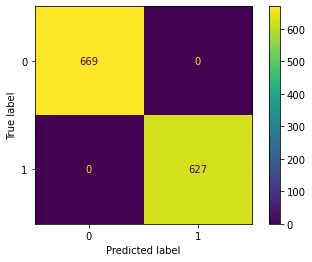

In [31]:
# Generating a report for all the training scores
print('Model 1: Training Data Scores')
print('-----------------------------')
print(f'Training Accuracy:  {accuracy_score(y_train, y_preds)}')
print(f'Training Precision: {precision_score(y_train, y_preds)}')
print(f'Training Recall:    {recall_score(y_train, y_preds)}')
ConfusionMatrixDisplay.from_predictions(y_train, y_preds);

DecisionTree Iteration 1 Initial Interpretations:
> - The model appears to be very overfit, as evidenced by all scores of 1.0
> - When I next cross-validate the training data, I will likely see a lower value for all the scores, as this model isn't likely to remain perfect.

#### Cross-Validation on DecisionTree Iteration 1:

In [32]:
print(f'CV Accuracy:  {cross_val_score(tree_1, X_train, y_train, cv=5)}')
print(f'CV Precision: {cross_val_score(tree_1, X_train, y_train, scoring="precision", cv=5)}')
print(f'CV Recall:    {cross_val_score(tree_1, X_train, y_train, scoring="recall", cv=5)}')

CV Accuracy:  [0.83846154 0.85714286 0.82239382 0.76061776 0.82625483]
CV Precision: [0.83333333 0.86178862 0.80152672 0.74045802 0.80769231]
CV Recall:    [0.83333333 0.84126984 0.84       0.776      0.84      ]


In [33]:
print(f'CV Accuracy:  {cross_val_score(tree_1, X_train, y_train, cv=5).mean().round(2)}')
print(f'CV Precision: {cross_val_score(tree_1, X_train, y_train, scoring="precision", cv=5).mean().round(2)}')
print(f'CV Recall:    {cross_val_score(tree_1, X_train, y_train, scoring="recall", cv=5).mean().round(2)}')

CV Accuracy:  0.82
CV Precision: 0.81
CV Recall:    0.83


#### DecisionTree Iteration 1 Interpretations:
> - After cross-validating, the first iteration of the DecisionTree model was definitely overfit, as evidenced by the lower scores for Accuracy, Precision, and Recall.

#### Focus on Precision Score and Reducing False Positives:
> The precision score represents the 'False Positives' generated by the model, this means the model is predicting that a student will re-enroll (designated with a 1 in the confusion matrix above) when they in fact do not re-enroll the following summer (designated by a 0 marker). 
> - The precision score represents all of the students that were incorrectly predicted to re-enroll the next summer when they do not in fact choose to travel with SunStride again. This mistaken prediction could cause the SunStride HQ to allocate funds for this higher expected enrollment, over-budgeting and ultimately being left with unfilled trips.
> - For many of the outfitters that SunStride works with, a flat rate is charged regardless of the trip capacity, thus causing SunStride to have to take a loss for these unfilled spots.
> - The recall score, in this case, represents the model's generation of False Negatives. 
>> - A False Negative in this case represents the instances where the model has designated a student will NOT re-enroll the next summer but they actually do.
>> - Yes, this figure could represent money left on the table, defined as an opportunity for SunStride to fill a trip spot that the company has not allocated resources for.
>> - However, SunStride does not ultimately lose any money out of pocket in these instances and would be able to add the student to the Waitlist for the next summer, which can build anticipation for students and families for the next season.

#### Analyzing Feature Importances:
> - Identifying which features contributed the most to the DecisionTree's classification process.

In [34]:
tree_1.feature_importances_

array([1.00425357e-02, 4.01967008e-02, 5.74506770e-02, 0.00000000e+00,
       2.47173171e-03, 9.90201108e-03, 3.10532376e-03, 2.43068023e-03,
       1.08892428e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.28579036e-03, 3.86208080e-03, 1.66255269e-02, 0.00000000e+00,
       1.65517749e-03, 2.05977643e-03, 2.44456983e-03, 2.74041187e-03,
       2.33837312e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.50136507e-03, 0.00000000e+00, 5.24219498e-03, 2.29014616e-03,
       0.00000000e+00, 0.00000000e+00, 4.36723572e-03, 8.37825733e-03,
       4.69517663e-03, 2.12598353e-03, 9.39015725e-04, 0.00000000e+00,
       3.83129610e-03, 7.72034976e-04, 2.32532252e-03, 2.34977127e-03,
       1.50470681e-03, 2.80878604e-03, 2.21716798e-03, 2.14195805e-03,
       6.02374457e-03, 6.32804780e-03, 8.91024205e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.92563337e-03, 2.73119633e-03, 9.68389005e-04, 3.74071857e-03,
      

In [35]:
tree_1.feature_names_in_

array(['2021 > Grade_10th', '2021 > Grade_11th', '2021 > Grade_12th',
       '2021 > Grade_6th', '2021 > Grade_7th', '2021 > Grade_8th',
       '2021 > Grade_9th', 'Gender_Female', 'Gender_Male',
       'Lead source_Advertisement', 'Lead source_Camp Advisory Service',
       'Lead source_Catalog', 'Lead source_Competitor',
       'Lead source_Family', 'Lead source_Friend',
       'Lead source_Google Ad', 'Lead source_Home Presentation',
       "Lead source_I'm a Moondance Alumni",
       "Lead source_I'm a sibling of a Moondance Alumni",
       'Lead source_No Source', 'Lead source_School Auction',
       'Lead source_Social Media',
       'Lead source_Summer Opportunities Fair', 'Lead source_Teacher',
       'Lead source_Web Search', 'Lead source_Website',
       'Lead source_Word of Mouth',
       '2021 > trip + section names (all)_Belize+Costa Rica 1',
       '2021 > trip + section names (all)_Belize+Costa Rica 1B',
       '2021 > trip + section names (all)_Belize+Costa Rica 1B, Can

In [36]:
pd.DataFrame(dict(zip(tree_1.feature_names_in_, tree_1.feature_importances_)), 
             index=[0]).T.sort_values(by=0, ascending=False).head(10)

,0
Years at camp,0.441414
2021 > Grade_12th,0.057451
2021 > Grade_11th,0.040197
2021 ^^Interested in Another Trip?_Yes,0.029822
2021 ^^^^Leader Rating of Student,0.026413
2021 ^Expectations_Met expectations,0.019704
2021 > Enrolled sibling count,0.017314
Lead source_Friend,0.016626
rating,0.012055
2021 ^^Interested in Another Trip?_Not Sure,0.011962


# ADD A VISUAL HERE?? TABLEAU

### Grid Searching for Model Type 1: DecisionTree Classifier
> - I preformed a grid search next to identify the optimal hyperparameters for the DecisionTree model that would result in the best precision score.
> - I included all the default hyperparameter settings so the grid search will compare these options used in Model 1 as it iterates through making each of the new models with different hyperparameters tuned. 

In [37]:
# Defining the dictionary of hyperparameters and the settings to be input for each model iteration
params = {'max_depth': [None, 10, 25, 30, 35], 'min_samples_leaf': [1, 2, 3, 4, 5]}

# Instantiating a Grid Search, and defining the scoring option as 'precision'
grid_precision = GridSearchCV(estimator = tree_1, param_grid=params, cv=5, scoring=('precision'))

# Fitting the grid search to the training data:
grid_precision.fit(X_train, y_train);

In [38]:
# Pre-viewing the precision score to determine if this model improved this score, thus making
## it worth further analysis.
print(grid_precision.best_score_)
print(grid_precision.best_estimator_)

0.8199834769457646
DecisionTreeClassifier(max_depth=25, min_samples_leaf=3, random_state=23)


> - The model marginally improved the precision score with these tuned settings and I will look into it further.

### DecisionTree Classifer Tuned: Model 2
> - Based on the grid search results, I have tuned the DecisionTree to have the hyperparameters that optimize the prescision score:

In [39]:
tree_m2 = DecisionTreeClassifier(max_depth=25, min_samples_leaf=3, random_state=23)

Model 2: Training Data Scores
-----------------------------
Training Accuracy:  0.9228395061728395
Training Precision: 0.9149606299212598
Training Recall:    0.9266347687400319


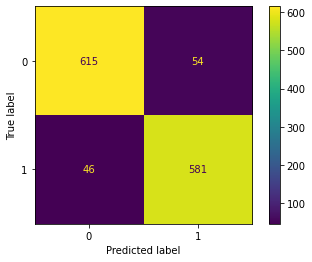

In [40]:
tree_m2.fit(X_train, y_train)
y_pred_2 = tree_m2.predict(X_train)
print('Model 2: Training Data Scores')
print('-----------------------------')
print(f'Training Accuracy:  {accuracy_score(y_train, y_pred_2)}')
print(f'Training Precision: {precision_score(y_train, y_pred_2)}')
print(f'Training Recall:    {recall_score(y_train, y_pred_2)}')
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_2);

In [41]:
print(f'CV Accuracy:  {cross_val_score(tree_m2, X_train, y_train, cv=5).mean().round(2)}')
print(f'CV Precision: {cross_val_score(tree_m2, X_train, y_train, scoring="precision", cv=5).mean().round(2)}')
print(f'CV Recall:    {cross_val_score(tree_m2, X_train, y_train, scoring="recall", cv=5).mean().round(2)}')

CV Accuracy:  0.83
CV Precision: 0.82
CV Recall:    0.84


## Evaluation: DecisionTree Classifier Models
> - Model 1, using all default hyperparameters was able to achieve a precision score of ~.81. Relatively speaking, this is a solid and usable score if SunStride is willing to accept this level of error.
> - Model 2, which was a tuned version of Model 1, only improved the precision score to ~.82, thus the tuing does not appear to have had a significant impact on model performance.
> - For future model iterations, I will try a more complex type of classifer to see if the added complexity will further improve the models' performance.


### RandomForest Classifer: Model 3

In [42]:
randfor_m3 = RandomForestClassifier(random_state=23)

In [43]:
randfor_m3.fit(X_train, y_train)

RandomForestClassifier(random_state=23)

Model 3: Training Data Scores
-----------------------------
Training Accuracy:  1.0
Training Precision: 1.0
Training Recall:    1.0


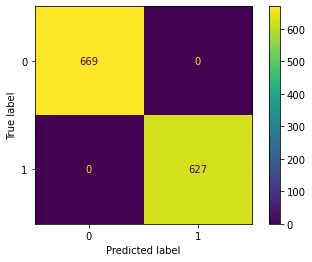

In [44]:
y_pred_rf = randfor_m3.predict(X_train)

print('Model 3: Training Data Scores')
print('-----------------------------')
print(f'Training Accuracy:  {accuracy_score(y_train, y_pred_rf)}')
print(f'Training Precision: {precision_score(y_train, y_pred_rf)}')
print(f'Training Recall:    {recall_score(y_train, y_pred_rf)}')
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_rf);

In [45]:
print(f'CV Accuracy:  {cross_val_score(randfor_m3, X_train, y_train, cv=5).mean().round(2)}')
print(f'CV Precision: {cross_val_score(randfor_m3, X_train, y_train, scoring="precision", cv=5).mean().round(2)}')
print(f'CV Recall:    {cross_val_score(randfor_m3, X_train, y_train, scoring="recall", cv=5).mean().round(2)}')

CV Accuracy:  0.85
CV Precision: 0.82
CV Recall:    0.88


#### RandomForest Model 3 Iteration Interpretations:
> - After cross-validating, it appears that the first iteration of the RandomForest model was definitely overfit just like the first DecisionTree Model - once again as evidenced by perfect training scores and then the lower scores for Accuracy, Precision, and Recall from cross-validation.
> - The precision score using the default hyperparameters appears to be about equal to the tuned iteration of the DecisionTree Classifier, so at least it appears to be starting at the best version of the last model type. I will now attempt to tune this model type to optimize the precision score.

### Grid Searching for Model 3: RandomForest Classifier
> - Now, I will repeat the grid searchign process for the RFC to identify the optimal hyperparameters for the RandomForest model that would result in the best precision score.
> - Agian, I included all the default hyperparameter settings so the grid search will compare these options used in Model 3 as it iterates through making each of the new models with different hyperparameters tuned. 

In [46]:
rf_params = {'n_estimators': [10, 50, 100, 150, 200], 'max_depth': [None, 5, 10, 20, 25, 40, 45, 50, 55, 60], 
                 'min_samples_leaf': [1, 2, 3, 4, 5]}

In [47]:
rf_grid = GridSearchCV(estimator=randfor_m3, param_grid=rf_params, cv=5, scoring='precision')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=23),
             param_grid={'max_depth': [None, 5, 10, 20, 25, 40, 45, 50, 55, 60],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='precision')

In [48]:
print(rf_grid.best_score_)
print(rf_grid.best_estimator_)
print(rf_grid.best_params_)

0.8291727608172191
RandomForestClassifier(max_depth=45, n_estimators=10, random_state=23)
{'max_depth': 45, 'min_samples_leaf': 1, 'n_estimators': 10}


### RandomForest Classifer Tuned: Model 4
> - Based on these second grid search results, I have tuned the RandomForest model to have the hyperparameters that optimize the prescision score:

In [49]:
randfor_m4 = RandomForestClassifier(max_depth=45, n_estimators=10, random_state=23)

Model 4: Training Data Scores
-----------------------------
Training Accuracy:  0.9930555555555556
Training Precision: 0.9936102236421726
Training Recall:    0.9920255183413078


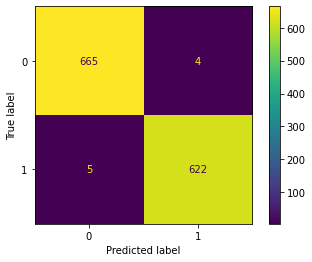

In [50]:
randfor_m4.fit(X_train, y_train)
y_pred_4 = randfor_m4.predict(X_train)
print('Model 4: Training Data Scores')
print('-----------------------------')
print(f'Training Accuracy:  {accuracy_score(y_train, y_pred_4)}')
print(f'Training Precision: {precision_score(y_train, y_pred_4)}')
print(f'Training Recall:    {recall_score(y_train, y_pred_4)}')
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_4);

In [51]:
print(f'CV Accuracy:  {cross_val_score(randfor_m4, X_train, y_train, cv=5).mean().round(2)}')
print(f'CV Precision: {cross_val_score(randfor_m4, X_train, y_train, scoring="precision", cv=5).mean().round(2)}')
print(f'CV Recall:    {cross_val_score(randfor_m4, X_train, y_train, scoring="recall", cv=5).mean().round(2)}')

CV Accuracy:  0.83
CV Precision: 0.83
CV Recall:    0.83


In [52]:
randfor_m4.feature_importances_

array([1.13449343e-02, 3.02603569e-02, 3.11938190e-02, 2.96232041e-03,
       3.90105405e-03, 1.14168710e-02, 1.12673291e-02, 1.80517414e-02,
       1.12237430e-02, 1.32529505e-03, 0.00000000e+00, 4.94723749e-04,
       3.27001692e-03, 7.03605203e-03, 1.52590419e-02, 0.00000000e+00,
       1.32695423e-03, 6.28884364e-03, 4.03823052e-03, 6.42911786e-04,
       9.34553932e-04, 2.03847697e-03, 0.00000000e+00, 8.93790592e-04,
       5.46979756e-03, 2.57202259e-05, 1.02519865e-02, 2.84170696e-03,
       1.95850058e-03, 0.00000000e+00, 4.55337556e-03, 6.08397475e-03,
       4.00956573e-03, 2.63231107e-03, 1.87868830e-03, 6.58402796e-03,
       1.47682923e-03, 4.37119296e-03, 2.15880542e-03, 2.99576205e-03,
       1.18872860e-03, 1.99171504e-03, 2.63658283e-04, 1.60362799e-03,
       3.57501532e-03, 7.22939166e-03, 7.57587348e-03, 1.77515946e-03,
       0.00000000e+00, 1.30429336e-03, 1.10569539e-03, 1.91768422e-03,
       2.91965820e-03, 5.18862032e-03, 3.53131668e-03, 5.86363597e-03,
      

In [53]:
randfor_m4.feature_names_in_

array(['2021 > Grade_10th', '2021 > Grade_11th', '2021 > Grade_12th',
       '2021 > Grade_6th', '2021 > Grade_7th', '2021 > Grade_8th',
       '2021 > Grade_9th', 'Gender_Female', 'Gender_Male',
       'Lead source_Advertisement', 'Lead source_Camp Advisory Service',
       'Lead source_Catalog', 'Lead source_Competitor',
       'Lead source_Family', 'Lead source_Friend',
       'Lead source_Google Ad', 'Lead source_Home Presentation',
       "Lead source_I'm a Moondance Alumni",
       "Lead source_I'm a sibling of a Moondance Alumni",
       'Lead source_No Source', 'Lead source_School Auction',
       'Lead source_Social Media',
       'Lead source_Summer Opportunities Fair', 'Lead source_Teacher',
       'Lead source_Web Search', 'Lead source_Website',
       'Lead source_Word of Mouth',
       '2021 > trip + section names (all)_Belize+Costa Rica 1',
       '2021 > trip + section names (all)_Belize+Costa Rica 1B',
       '2021 > trip + section names (all)_Belize+Costa Rica 1B, Can

In [54]:
pd.DataFrame(dict(zip(randfor_m4.feature_names_in_, randfor_m4.feature_importances_)), 
             index=[0]).T.sort_values(by=0, ascending=False).head(10)

,0
Years at camp,0.330582
2021 ^^Interested in Another Trip?_Yes,0.043137
2021 ^^^^Leader Rating of Student,0.038928
2021 > Grade_12th,0.031194
2021 > Grade_11th,0.030260
2021 ^^Interested in Another Trip?_Not Sure,0.026767
rating,0.021248
2021 > Enrolled sibling count,0.018572
Gender_Female,0.018052
Lead source_Friend,0.015259


## Evaluation: RandomForest Classifier Models
> - Model 3, using the random forst default hyperparameters was able to achieve a precision score of ~.82. This is approximately equal to the tuned DecisionTree classifier from Model 2.
> - Model 4, the tuned version of Model 3, only improved the precision score to ~.83.
> - Again, it does not appear that tuning has had a significant impact on the precision score, however, as 4th model does have the highest precision score after cross validating AND the model performed will on training data (much better than the DecisionTree model) then I will move forward in my analysis and use this model as my final.

## Final Model Selection = RandomForest Tuned: Model 4

In [55]:
final_model = randfor_m4

Final Model: Testing Data Scores
-----------------------------
Test Data Accuracy:  0.85
Test Data Precision: 0.83
Test Data Recall:    0.86


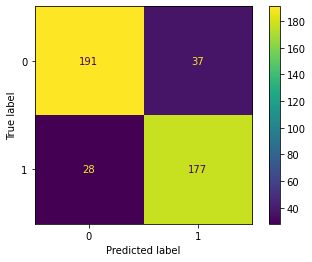

In [57]:
y_pred_test = final_model.predict(X_test)
print('Final Model: Testing Data Scores')
print('-----------------------------')
print(f'Test Data Accuracy:  {accuracy_score(y_test, y_pred_test).round(2)}')
print(f'Test Data Precision: {precision_score(y_test, y_pred_test).round(2)}')
print(f'Test Data Recall:    {recall_score(y_test, y_pred_test).round(2)}')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);